<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-JulioOsvaldoHernandezBucio/blob/main/Semana8_Kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Julio Osvaldo Hernandez Bucio. A01794366. Dra. María de la Paz Rico Fernández. Ciencia y Analitica de datos. 09/11/22

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from sklearn.cluster import KMeans

Importa la base de datos

In [3]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [4]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [6]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

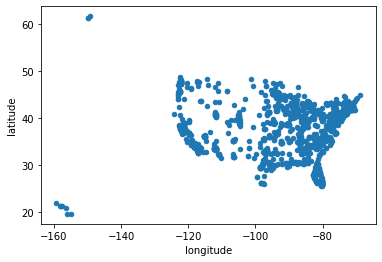

In [7]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [8]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [10]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [11]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [12]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [13]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

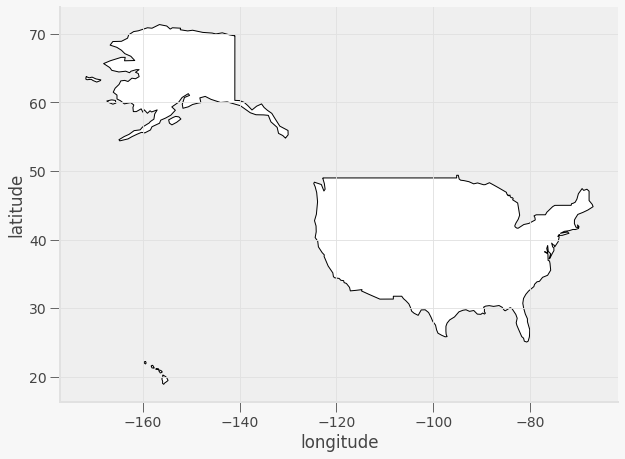

In [14]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

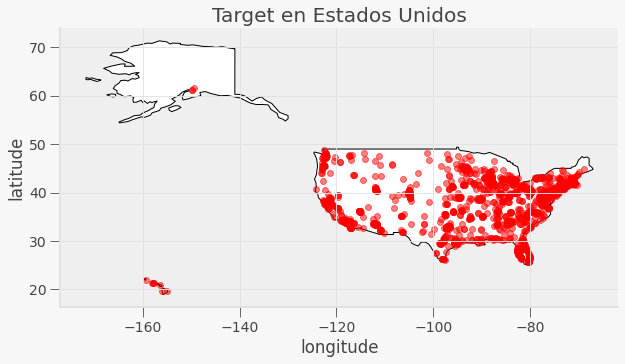

In [15]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

# Metodo de codo

Se usara el método del codo para determinar la cantidad óptima de grupos. En algún momento, aumentar la cantidad de clústeres solo dará como resultado ganancias marginales o la pérdida de información. Si seleccionamos la varianza más baja posible, entonces cada punto tendría su propio grupo. Vamos a buscar aquí la ubicación del gráfico con el mayor cambio en la suma de cuadrados dentro del grupo (debería verse como un codo).

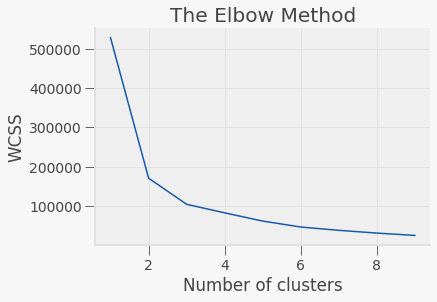

In [16]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(latlong.values)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Como no podemos ver un "pico" del codo bien definido, (se observan dos), procederemos a hacer un analisis de Siluetas

# Análisis de silueta

El análisis de silueta se puede utilizar para estudiar la distancia de separación entre los grupos resultantes. El gráfico de silueta muestra una medida de qué tan cerca está cada punto en un grupo de puntos en los grupos vecinos y, por lo tanto, proporciona una forma de evaluar parámetros como el número de grupos visualmente. Esta medida tiene un rango de [-1, 1].

Los coeficientes de silueta (como se denominan estos valores) cercanos a +1 indican que la muestra está lejos de los conglomerados vecinos. Un valor de 0 indica que la muestra está en o muy cerca del límite de decisión entre dos conglomerados vecinos y los valores negativos indican que esas muestras pueden haber sido asignadas al conglomerado equivocado.

For n_clusters = 2 The average silhouette_score is : 0.6303505031760588
For n_clusters = 3 The average silhouette_score is : 0.4820033057646935
For n_clusters = 4 The average silhouette_score is : 0.4718343565961516
For n_clusters = 5 The average silhouette_score is : 0.5234740137140707
For n_clusters = 6 The average silhouette_score is : 0.5333930683484338


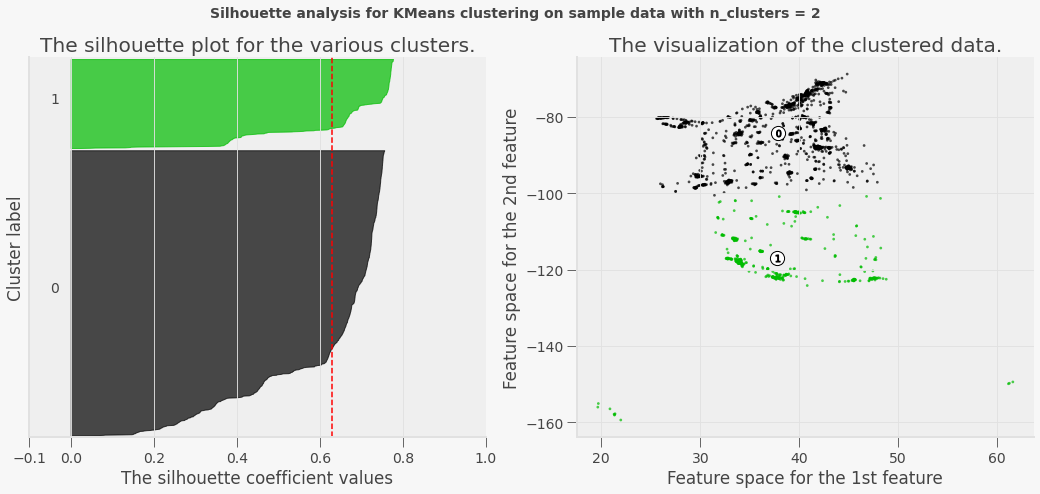

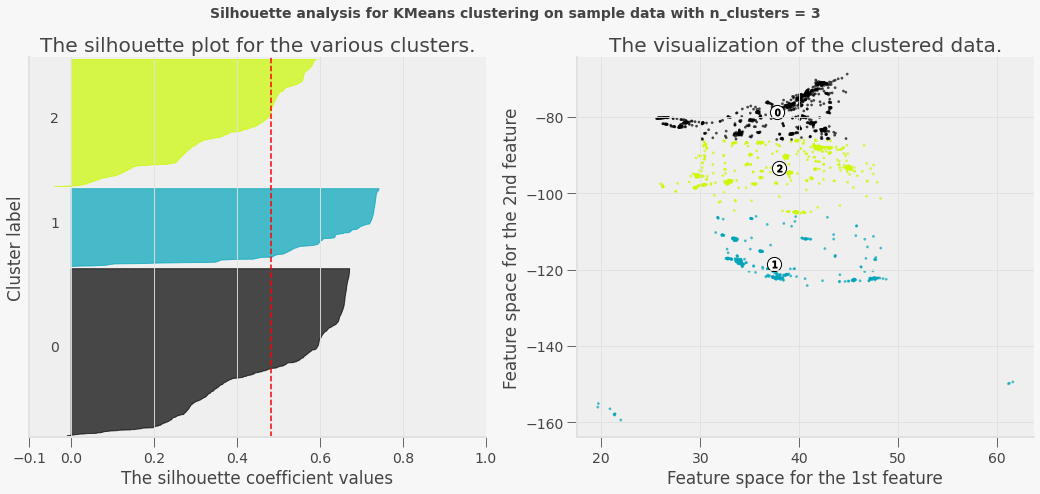

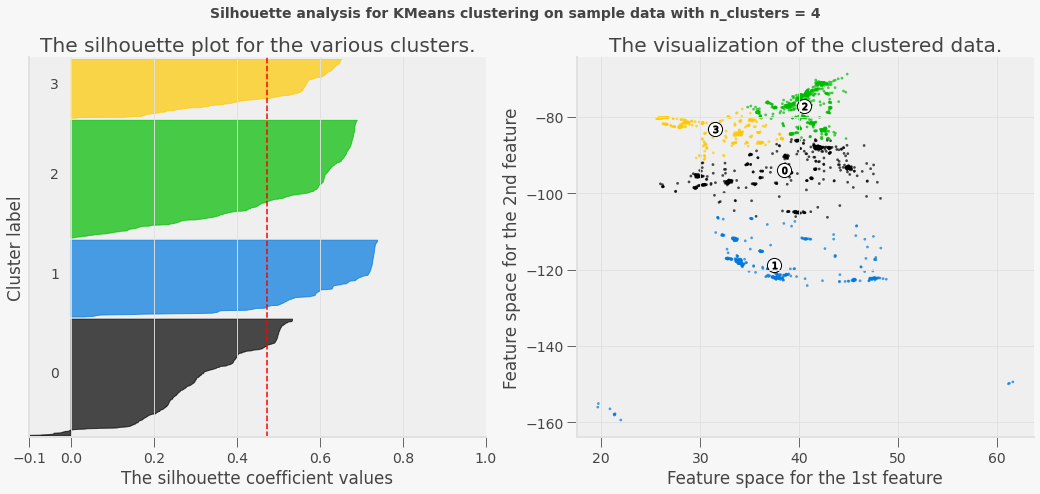

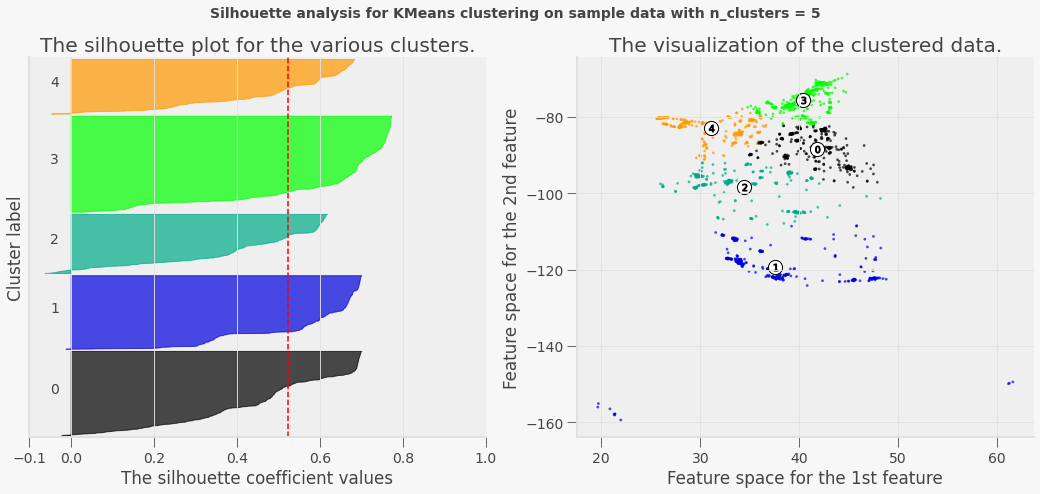

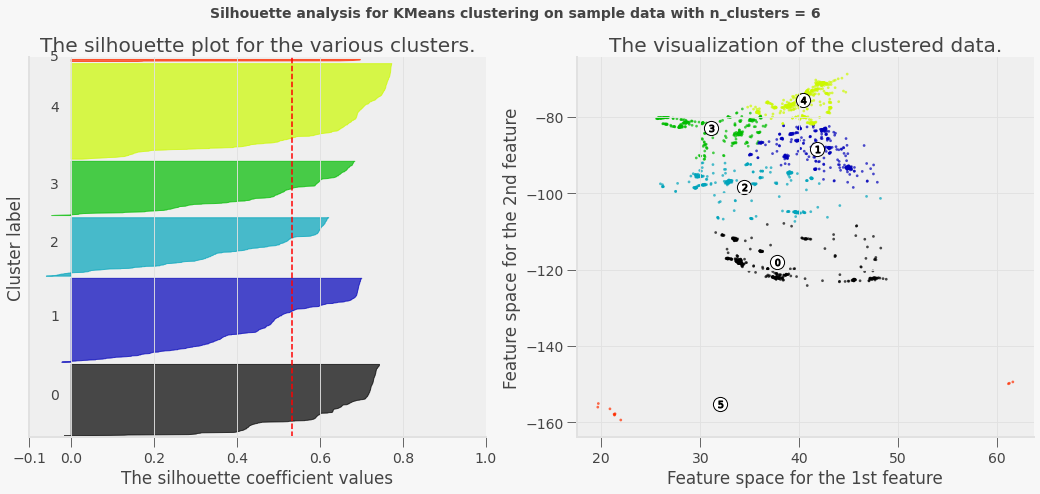

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm


range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(latlong.values) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(latlong.values)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(latlong.values, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(latlong.values, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        latlong.values[:, 0], latlong.values[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

# ¿Cómo se eligió el número de almacenes?

A partir del gráfico de silueta. En este se puede visualizar el tamaño del grupo. El diagrama de silueta para el clúster 0 cuando n_clusters es igual a 2, es de mayor tamaño debido a la agrupación de los 3 subconjuntos en un solo clúster grande. 

Descartaremos el caso de n = 3 porque puede observarse que las siluetas pasan el coeficiente con mucha varianza en cada grupo y hay un poco de uniformidad en las siluetas

Descartaremos el caso de n = 4 ya que hay mayor uniformidad entre las siluetas.

Descartaremos el caso de n = 6 ya que el ultimo cluster no representa una silueta que pueda ser de utilidad (linea roja) ademas que en la grafica de dispersion (derecha) tambien puede observarse que no existe la misma densidad como los otros grupos.

Usaremos 5 clusters dado que se puede observar una mayor uniformidad de la silueta para cada grupo, y el coeficiente indica que hay una buena distancia entre los clusters vecinos. (Tambien se puede observar que es el primer pico en la grafica de codo)

In [19]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 5,  max_iter=400)
kmeans.fit(latlong.values) # Compute k-means clustering.
y_kmeans = kmeans.fit_predict(latlong.values)
k=pd.DataFrame(y_kmeans, columns=['cluster'])
gdf=gdf.join(k)

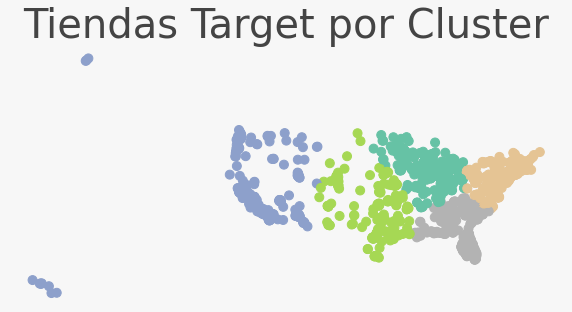

In [20]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax.set_title("Tiendas Target por Cluster", fontsize=40)
ax.set_axis_off()
gdf.plot(column='cluster',cmap='Set2', ax=ax, markersize=80)
plt.show()

In [21]:
dtCenters = pd.DataFrame(columns =(['latitude','longitude', 'Coordinates']))

In [22]:
dtCenters["latitude"] = kmeans.cluster_centers_[:,0]

In [23]:
dtCenters["longitude"] = kmeans.cluster_centers_[:,1]

In [24]:
dtCenters["Coordinates"] = list(zip(dtCenters.longitude, dtCenters.latitude))
dtCenters["Coordinates"] = dtCenters["Coordinates"].apply(Point)

In [25]:
dtCenters

,latitude,longitude,Coordinates
0,41.744765,-88.336339,POINT (-88.33633884658823 41.744764698588234)
1,37.579774,-119.176343,POINT (-119.17634307255436 37.57977423831522)
2,34.420357,-98.266337,POINT (-98.26633715912162 34.42035677094595)
3,40.341324,-75.571971,POINT (-75.57197123263599 40.34132416882845)
4,31.086863,-82.918371,POINT (-82.91837107169117 31.086862587867646)


In [26]:
gdf = gpd.GeoDataFrame(dtCenters, geometry="Coordinates")

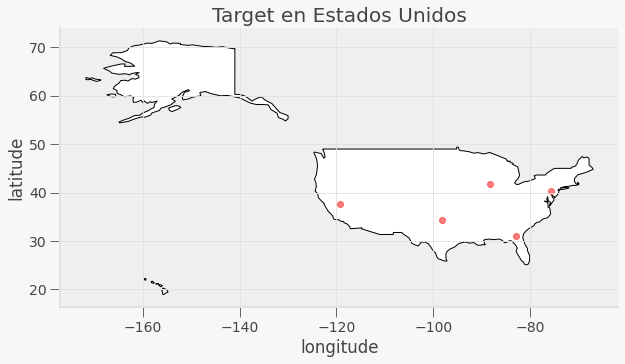

In [27]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

Obtenemos el numero de datos por cada cluster (Tienda por Almacen)

In [28]:
labels = kmeans.labels_

clusterCount = np.bincount(labels)

clusterCount

array([422, 368, 296, 480, 273])

Obtenemos los centroides y su distancia al centro

In [33]:
latlong1 =dtCenters[["latitude","longitude"]]

X_dist = kmeans.transform(latlong1)**2

dfDistances = pd.DataFrame(X_dist.sum(axis=1).round(2), columns=['sqdist'])

dfDistances.head()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,sqdist
0,1428.55
1,4681.43
2,1396.23
3,2763.57
4,1886.03


# Preguntas

**Almacen 1**

*Latitud*: 41.744765.<br>
*Longitud*: -88.336339.<br>
*Ciudad*: Aurora. Illinois.<br>
*Numero de tiendas a surtir*: 422.<br>  
*¿sabes a que distancia estará?* La distancia al centro es de 1428.55.

**Almacen 2**

*Latitud*: 37.5797742383152.<br>
*Longitud*: -119.176343.<br>
*Ciudad*: Mammmoth Lakes. California.<br>
*Numero de tiendas a surtir*: 368.<br>  
*¿sabes a que distancia estará?*: La distancia al centro es de 4681.43.

**Almacen 3**

*Latitud*: 34.420357.<br>
*Longitud*: -98.266337.<br>
*Ciudad*: Walters. Oklahoma.<br>
*Numero de tiendas a surtir*: 296.<br>  
*¿sabes a que distancia estará?*: La distancia al centro es de 1396.23.

**Almacen 4**

*Latitud*: 40.341324.<br>
*Longitud*: -75.571971.<br>
*Ciudad*: Sassamansville. Pensilvania.<br>
*Numero de tiendas a surtir*: 480<br>  
*¿sabes a que distancia estará?*: La distancia al centro es de 2763.57.

**Almacen 5**

*Latitud*: 31.086863.<br>
*Longitud*: -82.918371.<br>
*Ciudad*: Du Pont. Georgia.<br>
*Numero de tiendas a surtir*: 273<br>  
*¿sabes a que distancia estará?*: La distancia al centro es de 1886.03.

# Conclusiones

**La ultima pregunta no especifica la distancia respecto a que? Al centroide, a las tiendas, entre los almacenes?**

¿Qué librerías nos pueden ayudar a graficar este tipo de datos?

Las dadas en el ejemplo fueron de mucha ayuda, en mi opinion *Geopandas* me parecio la mas importante ya que como estamos trabajando con informacion geografica, en particular con latitudes y longitudes esta es indispensable.

Otras librerias que utilice para tomar la decision de cuantos clusters tomar fueron las de *silhouette_samples*, *silhouette_score* para ayudarnos a graficar El analisis por siluetas. 

¿Consideras importante que se grafique en un mapa?, ¿por qué?

En este caso si, ya que estamos trabajando con datos que nos brindan informacion precisa acerca de la ubicacion. Al momento de visualizar el centro de cluster (Almacen) nos podemos dar una idea rapida de como podrian resultar las operaciones de la empresa despues del estudio.

# Fuentes

https://samdotson1992.github.io/SuperGIS/blog/k-means-clustering/

https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1

Por que se decidio usar los coeficientes de silueta https://bl.ocks.org/rpgove/0060ff3b656618e9136b

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html